In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

from myutil import *
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets

from sklearn.impute import SimpleImputer

/Users/odahideto/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_genba = pd.read_table('../data/train_genba.tsv')
train_goto =  pd.read_table('../data/train_goto.tsv')

train = pd.merge(train_genba, train_goto, on='pj_no')

print(train_genba.shape)
print(train_goto.shape)
print(train.shape)

train_src_X = train.drop('keiyaku_pr', axis=1)
train_src_Y = train.keiyaku_pr

test_genba = pd.read_table('../data/test_genba.tsv')
test_goto =  pd.read_table('../data/test_goto.tsv')

test_X = pd.merge(test_genba, test_goto, on='pj_no')
print('train_X shape', train_src_X.shape)
print('test_X shape', test_X.shape)

# light GBMのカテゴリ変数の扱い
#https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm

train_quantity = pd.DataFrame()
train_categorical = pd.DataFrame()

for col in train_src_X.columns:
    if train_src_X[col].dtypes == object:
        train_src_X[col] = train_src_X[col].astype('category')
        train_categorical[col] = train_src_X[col]
    else:
        train_quantity[col] = train_src_X[col]
        
for col in test_X.columns:
    if test_X[col].dtypes == object:
        test_X[col] = test_X[col].astype('category')

train_src_X.head()

(2781, 140)
(6461, 19)
(6461, 158)
train_X shape (6461, 157)
test_X shape (4273, 157)


,pj_no,jukyo,chiseki_js_hb,chiseki_kb_hb,yoto1,yoto2,kempei1,kempei2,yoseki1,yoseki2,josui,gesui,gas,usui,tateuri_su,tochiuri_su,joken_su,hy1f_date_su,hy2f_date_su,hy3f_date_su,road1_hk,road1_sb,road1_fi,road1_mg,road2_hk,road2_sb,road2_fi,road2_mg,road3_hk,road3_sb,road3_fi,road3_mg,road4_hk,road4_sb,road4_fi,road4_mg,kaoku_um,kaoku_hb,yheki_kotei,yheki_umu,yheki_yohi,gk_sho_kyori,gk_chu_kyori,kborjs,hw_status,toshikuiki1,toshikuiki2,kodochiku,chikukeikaku,keikakuroad,kaihatsukyoka,t53kyoka,hokakyoka,bokachiiki,minmenseki,hokakisei1,hokakisei2,hokakisei3,hokakisei4,kinshijiko,rosenka_hb,koji_hb,kijun_hb,mseki_yt_hb,mseki_rd_hb,mseki_dp_hb,tc_mseki_min_hb,tc_mseki_max_hb,tt_mseki_min_hb,tt_mseki_max_hb,tc_mseki_avg_hb,tt_mseki_avg_hb,fi4m_yohi,fi3m_yohi,fi4m_kyori,fi3m_kyori,bus_yohi,bus_hon,sho_conv,sho_super,sho_shoten,sho_market,shu_jutaku,shu_park,shu_shop,shu_factory,shu_hvline,shu_tower,shu_bochi,shu_sogi,shu_zoki,shu_kokyo,shu_highway,shu_kaido,shu_line_ari,shu_line_nashi,shu_soon,gk_yoc_tm,gk_sho_tm,gk_chu_tm,rs_e_kdate2,rs_e_kdate3,rs_e_parking,rs_e_zoki,rs_e_m_ari,rs_e_m_nashi,rs_e_tahata,rs_w_kdate2,rs_w_kdate3,rs_w_parking,rs_w_zoki,rs_w_m_ari,rs_w_m_nashi,rs_w_tahata,rs_s_kdate2,rs_s_kdate3,rs_s_parking,rs_s_zoki,rs_s_m_ari,rs_s_m_nashi,rs_s_tahata,rs_n_kdate2,rs_n_kdate3,rs_n_parking,rs_n_zoki,rs_n_m_ari,rs_n_m_nashi,rs_n_tahata,rosen_nm1,eki_nm1,bas_toho1,eki_kyori1,bastei_nm1,teiho1,rosen_nm2,eki_nm2,bas_toho2,eki_kyori2,bastei_nm2,teiho2,id,tc_mseki,tt_mseki,levelplan,fukuin,road_st,magutchi,setsudo_hi,setsudo_kj,jigata,hiatari,niwasaki,garage,kobetsu1,kobetsu2,kobetsu3,kobetsu4
0,0,埼玉県朝霞市泉水,109.26,109.10,工業地域,NaN,60,0.0,200,0.0,公営,公共下水,個別プロパン,宅内処理,1.0,0.0,0.0,0.0,1.0,0.0,北,私道,4.0,7.0,東,私道,4.0,10.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,（無）,0.0,0.6,（無）,（不要）,800,1000,実測,更地,市街化区域,NaN,第2種,（無）,（無）,（不要）,（不要）,（不要）,防火指定無,0.0,NaN,NaN,NaN,NaN,（無）,135000,188000,197000,109.26,0.0,0.00,109.26,109.26,104.43,104.43,109.26,104.43,（不要）,（不要）,0.0,0.0,（不要）,NaN,NaN,NaN,NaN,NaN,○,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,10,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,○,NaN,NaN,NaN,NaN,NaN,NaN,NaN,○,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,東武東上線,朝霞台,徒歩,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_0000,109.26,104.43,2F/4LDK,4.0,問題なし,9.9,東,良い,整形地,普通,4.0,1,床暖房付,NaN,NaN,NaN
1,1,埼玉県川越市大字的場,136.15,136.00,第一種低層住居専用地域,NaN,60,0.0,200,0.0,公営,公共下水,個別プロパン,宅内処理,1.0,0.0,0.0,0.0,1.0,0.0,北西,公道,4.2,9.3,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,（無）,0.0,0.0,（無）,（不要）,1680,1840,実測,更地,市街化区域,NaN,指定無,（無）,（無）,（不要）,（不要）,（不要）,22条区域,NaN,NaN,農地法,NaN,NaN,（無）,68000,84900,48600,136.15,0.0,0.00,136.15,136.15,109.10,109.10,136.15,105.16,（不要）,（不要）,0.0,0.0,（不要）,NaN,NaN,NaN,NaN,NaN,○,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,21,23,○,NaN,NaN,NaN,NaN,NaN,NaN,○,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,○,NaN,NaN,NaN,NaN,NaN,NaN,JR川越線,的場,徒歩,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_0001,136.11,105.16,2F/4LDK,4.2,問題なし,9.3,北西,普通,不整形地,普通,3.0,1,NaN,NaN,NaN,NaN
2,2,埼玉県川口市安行原,86.92,86.52,第一種低層住居専用地域,NaN,50,0.0,100,0.0,私営,個別浄化槽,個別プロパン,宅内処理,1.0,0.0,0.0,0.0,1.0,0.0,東,私道,4.0,11.1,北,公道,3.8,5.2,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,（有）,62.1,0.2,（無）,（不要）,600,550,実測,建物有,市街化区域,NaN,指定無,（無）,（無）,（不要）,（不要）,（不要）,防火指定無,NaN,NaN,NaN,NaN,NaN,（無）,83000,116000,124000,86.92,0.0,0.00,86.92,86.92,85.96,85.96,86.92,85.96,（不要）,（不要）,0.0,0.0,（要）,35.0,○,NaN,NaN,NaN,○,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,8,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,○,NaN,NaN,NaN,NaN,○,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,埼玉高速鉄道線,新井宿,徒歩,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_0002,87.07,85.94,2F/4LDK,4.0,問題なし,11.1,東,普通,整形地,普通,2.8,1,NaN,NaN,NaN,NaN
3,3,埼玉県草加市松江,164.91,164.07,工業地域,NaN,60,0.0,200,0.0,公営,公共下水,都市ガス,宅内処理,1.0,0.0,0.0,0.0,1.0,0.0,南,公道,4.0,13.3,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,（無）,0.0,0.3,（無）,（不要）,1220,111,公簿,更地,市街化区域,NaN,指定無,（無）,（無）,（不要）,（不要）,（要）,防火指定無,NaN,NaN,NaN,NaN,NaN,（無）,91000,122000,113000,164.07,0.0,0.84,164.07,164.07,105.99,105.

In [3]:
train_quantity.describe()

,pj_no,chiseki_js_hb,chiseki_kb_hb,kempei1,kempei2,yoseki1,yoseki2,tateuri_su,tochiuri_su,joken_su,hy1f_date_su,hy2f_date_su,hy3f_date_su,road1_fi,road1_mg,road2_fi,road2_mg,road3_fi,road3_mg,road4_fi,road4_mg,kaoku_hb,yheki_kotei,gk_sho_kyori,gk_chu_kyori,minmenseki,rosenka_hb,koji_hb,kijun_hb,mseki_yt_hb,mseki_rd_hb,mseki_dp_hb,tc_mseki_min_hb,tc_mseki_max_hb,tt_mseki_min_hb,tt_mseki_max_hb,tc_mseki_avg_hb,tt_mseki_avg_hb,fi4m_kyori,fi3m_kyori,bus_hon,gk_yoc_tm,gk_sho_tm,gk_chu_tm,eki_kyori1,teiho1,eki_kyori2,teiho2,tc_mseki,tt_mseki,fukuin,magutchi,niwasaki,garage
count,6461.000000,6461.000000,6456.000000,6461.000000,5917.000000,6461.000000,5917.000000,6460.000000,6218.000000,6234.000000,6212.0,6458.000000,6274.000000,6461.000000,6461.000000,6210.000000,6210.000000,5965.000000,5965.000000,5920.000000,5920.000000,6268.000000,6461.00000,6461.000000,6461.000000,3679.000000,6461.000000,6461.000000,6.461000e+03,6461.000000,6432.000000,6430.000000,6461.000000,6461.000000,6461.000000,6461.000000,6461.000000,6460.000000,6131.000000,6102.000000,2956.000000,6461.000000,6461.000000,6461.000000,6461.000000,1391.000000,192.000000,90.000000,6461.000000,6461.000000,6367.000000,6367.000000,6461.000000,6461.000000
mean,1384.093794,736.291579,777.740861,57.785173,5.098868,165.551772,15.453777,4.539319,0.350917,0.048604,0.0,4.495819,0.097864,5.693631,20.442236,2.874895,12.959824,0.817205,5.065866,0.146098,1.429172,43.709947,0.38160,811.431512,1185.906826,68.518891,83047.520817,120167.063922,1.196350e+05,692.476624,55.936087,3.101868,134.538856,180.801856,96.516463,101.666443,145.048291,100.244232,1.742910,0.177042,29.764547,11.811175,10.461074,15.106176,15.258010,4.773544,12.697917,3.622222,140.288349,96.303482,5.557022,8.829752,3.841002,1.786411
std,806.583481,807.762451,873.449310,4.895278,16.620629,51.551108,51.675946,4.651619,1.672873,0.483694,0.0,4.778028,0.547433,3.007846,14.185390,4.143426,17.373378,2.338422,15.978411,0.907150,9.173202,155.951922,0.47153,504.475093,650.204398,72.182357,45109.023976,51723.169158,6.126838e+04,737.567502,138.147303,24.062456,48.339130,2602.782793,19.993146,13.861124,65.144367,14.831647,17.212068,3.066584,62.591329,7.580993,6.294150,8.140534,7.129941,3.031924,6.632649,1.632381,50.865584,24.355454,2.260369,4.548319,12.315084,0.747053
min,0.000000,39.160000,39.160000,40.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6.000000,10.000000,0.000000,0.000000,12000.000000,0.000000e+00,39.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.160000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,28.200000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,681.000000,216.510000,219.270000,60.000000,0.000000,100.000000,0.000000,2.000000,0.000000,0.000000,0.0,1.000000,0.000000,4.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.10000,480.000000,700.000000,0.000000,60000.000000,88200.000000,8.530000e+04,215.300000,0.000000,0.000000,105.320000,115.820000,95.220000,98.010000,112.550000,96.460000,0.000000,0.000000,0.000000,7.000000,6.000000,9.000000,10.000000,3.000000,5.000000,3.000000,110.080000,96.380000,4.000000,6.200000,2.000000,1.000000
50%,1376.000000,441.790000,457.125000,60.000000,0.000000,200.000000,0.000000,3.000000,0.000000,0.000000,0.0,3.000000,0.000000,5.000000,16.800000,1.900000,5.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.30000,720.000000,1100.000000,100.000000,85500.000000,114000.000000,1.150000e+05,435.610000,0.000000,0.000000,122.210000,136.000000,100.000000,104.490000,132.000000,102.460000,0.000000,0.000000,10.000000,10.000000,9.000000,14.000000,14.000000,4.000000,13.500000,3.000000,129.000000,102.260000,5.000000,8.500000,3.000000,2.000000
75%,2101.000000,919.520000,949.670000,60.000000,0.000000,200.000000,0.000000,6.000000,0.000000,0.000000,0.0,6.000000,0.000000,6.000000,25.10000

In [4]:
train_quantity.isnull().sum()

pj_no                 0
chiseki_js_hb         0
chiseki_kb_hb         5
kempei1               0
kempei2             544
yoseki1               0
yoseki2             544
tateuri_su            1
tochiuri_su         243
joken_su            227
hy1f_date_su        249
hy2f_date_su          3
hy3f_date_su        187
road1_fi              0
road1_mg              0
road2_fi            251
road2_mg            251
road3_fi            496
road3_mg            496
road4_fi            541
road4_mg            541
kaoku_hb            193
yheki_kotei           0
gk_sho_kyori          0
gk_chu_kyori          0
minmenseki         2782
rosenka_hb            0
koji_hb               0
kijun_hb              0
mseki_yt_hb           0
mseki_rd_hb          29
mseki_dp_hb          31
tc_mseki_min_hb       0
tc_mseki_max_hb       0
tt_mseki_min_hb       0
tt_mseki_max_hb       0
tc_mseki_avg_hb       0
tt_mseki_avg_hb       1
fi4m_kyori          330
fi3m_kyori          359
bus_hon            3505
gk_yoc_tm       

In [5]:
train_categorical.describe()

,jukyo,yoto1,yoto2,josui,gesui,gas,usui,road1_hk,road1_sb,road2_hk,road2_sb,road3_hk,road3_sb,road4_hk,road4_sb,kaoku_um,yheki_umu,yheki_yohi,kborjs,hw_status,toshikuiki1,toshikuiki2,kodochiku,chikukeikaku,keikakuroad,kaihatsukyoka,t53kyoka,hokakyoka,bokachiiki,hokakisei1,hokakisei2,hokakisei3,hokakisei4,kinshijiko,fi4m_yohi,fi3m_yohi,bus_yohi,sho_conv,sho_super,sho_shoten,sho_market,shu_jutaku,shu_park,shu_shop,shu_factory,shu_hvline,shu_tower,shu_bochi,shu_sogi,shu_zoki,shu_kokyo,shu_highway,shu_kaido,shu_line_ari,shu_line_nashi,shu_soon,rs_e_kdate2,rs_e_kdate3,rs_e_parking,rs_e_zoki,rs_e_m_ari,rs_e_m_nashi,rs_e_tahata,rs_w_kdate2,rs_w_kdate3,rs_w_parking,rs_w_zoki,rs_w_m_ari,rs_w_m_nashi,rs_w_tahata,rs_s_kdate2,rs_s_kdate3,rs_s_parking,rs_s_zoki,rs_s_m_ari,rs_s_m_nashi,rs_s_tahata,rs_n_kdate2,rs_n_kdate3,rs_n_parking,rs_n_zoki,rs_n_m_ari,rs_n_m_nashi,rs_n_tahata,rosen_nm1,eki_nm1,bas_toho1,bastei_nm1,rosen_nm2,eki_nm2,bas_toho2,bastei_nm2,id,levelplan,road_st,setsudo_hi,setsudo_kj,jigata,hiatari,kobetsu1,kobetsu2,kobetsu3,kobetsu4
count,6461,6461,512,6461,6461,6461,6461,6461,6461,3246,3246,887,887,171,171,6461,6461,6461,6461,6461,6461,67,6461,6461,6461,6461,6461,6461,6461,1780,850,186,36,6461,6461,6461,6461,2838,1606,164,200,5706,219,69,139,67,25,42,3,86,51,25,173,87,88,48,3730,84,295,76,59,154,369,3833,59,258,50,33,141,342,3630,125,252,100,53,141,271,3609,76,331,58,23,139,382,6461,6461,6461,314,192,192,586,90,6461,6106,6367,6366,6365,6366,6366,2647,433,266,49
unique,1234,12,9,2,2,3,3,9,3,8,3,8,3,7,2,2,2,2,3,7,4,3,6,2,2,2,2,2,6,20,19,7,3,2,2,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,27,204,3,95,16,56,3,35,6461,27,4,55,3,4,3,25,25,24,16
top,埼玉県川越市大字寺尾,第一種低層住居専用地域,第一種住居地域,公営,公共下水,都市ガス,宅内処理,東,公道,南,公道,北,公道,東,公道,（無）,（無）,（不要）,実測,更地,市街化区域,市街化区域,指定無,（無）,（無）,（不要）,（不要）,（不要）,防火指定無,景観法,農地法,埋蔵文化財,公拡法,（無）,（不要）,（不要）,（不要）,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,○,東武東上線,八潮,徒歩,浦和パークハイツ,東武伊勢崎線,草加,徒歩,レイクタウン北,train_6460,2F/4LDK,問題なし,南,良い,整形地,良い,眺望良,角地,行き止まり,裏道
freq,53,2186,192,6416,5639,4585,6027,1311,5907,771,2893,223,750,71,152,5058,6151,5968,3317,3739,5921,64,5837,5616,6228,4777,6275,5398,3631,950,617,108,28,6353,6293,6418,4856,2838,1606,164,200,5706,219,69,139,67,25,42,3,86,51,25,173,87,88,48,3730,84,295,76,59,154,369,3833,59,258,50,33,141,342,3630,125,252,100,53,141,271,3609,76,331,58,23,139,382,879,203,5002,23,33,15,366,7,1,5003,6054,1399,3467,4837,3470,547,93,34,10


In [6]:
# cityを追加
import re

train_src_X['jukyo'].value_counts()
pattern = r'(^.+?[市区郡])'
repatter = re.compile(pattern)

cities_train = []
for city in train_src_X.jukyo:
    city = city.replace('埼玉県', '')
    city = city.replace('さいたま市', '')
    result = repatter.match(city)
    if result != None:
        cities_train.append(result.group())
    else:
        print(city)
        cities_train.append(city)

train_src_X['city'] = cities_train
train_src_X['city'] = train_src_X['city'].astype('category')

cities_test = []
for city in test_X.jukyo:
    city = city.replace('埼玉県', '')
    city = city.replace('さいたま市', '')
    result = repatter.match(city)
    if result != None:
        cities_test.append(result.group())
    else:
        cities_test.append(city)

test_X['city'] = cities_test
test_X['city'] = test_X['city'].astype('category')

train_src_X.city.value_counts()

compare_columns(train_src_X, test_X)

にっさい花みず木
西鶴ヶ岡
西鶴ヶ岡
杉戸町内田
杉戸町内田
杉戸町内田
杉戸町内田
杉戸町内田
杉戸町内田
杉戸町内田
宮代町宮代台
大字下日出谷
杉戸町清地
松伏町田中
大字大谷口
大字大谷口
大字大谷口
大字水野字逃水
大字水野字逃水
大字南中丸
大字南中丸


True

### 特徴量選択

/Users/odahideto/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's mape: 0.0760069
[1000]	valid_0's mape: 0.0758914
[1500]	valid_0's mape: 0.0759407
[2000]	valid_0's mape: 0.0759816
Early stopping, best iteration is:
[1006]	valid_0's mape: 0.0758726


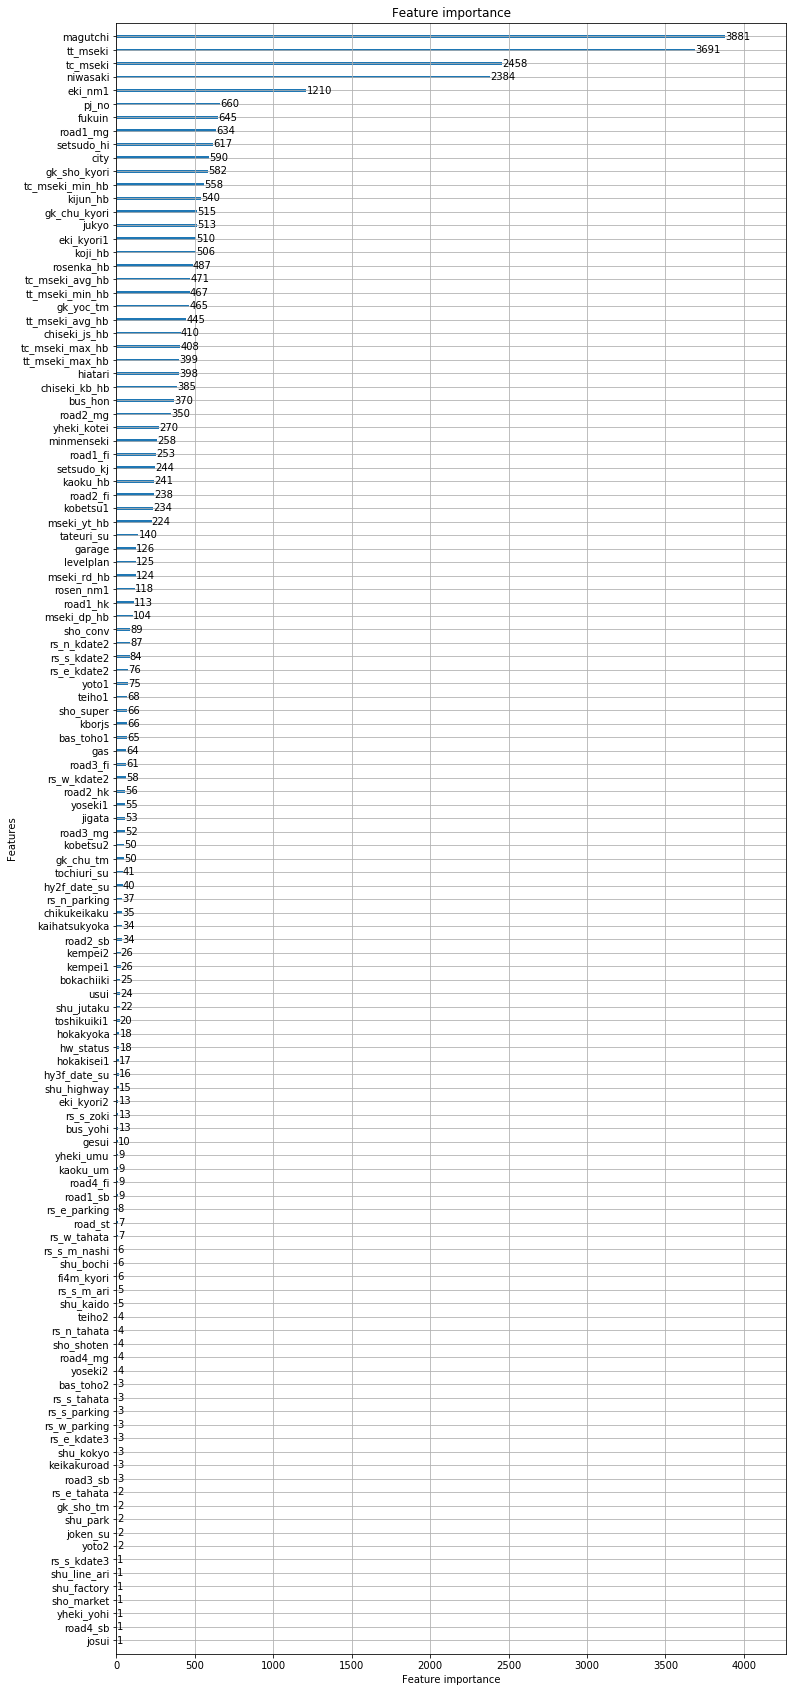

In [7]:
# データセットを生成する
X_train, X_eval, y_train, y_eval = train_test_split(train_src_X, train_src_Y,train_size=0.8)

# LightGBM のハイパーパラメータ
lgbm_params = {
    'objective': 'regression',
    'metric': 'mape',
}

# 上記のパラメータでモデルを学習する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=10000, verbose_eval=500, early_stopping_rounds=1000)

lgb.plot_importance(model, figsize=(12, 30))
plt.show()

In [9]:
model.feature_importance()

array([ 660,  513,  410,  385,   75,    2,   26,   26,   55,    4,    1,
         10,   64,   24,  140,   41,    2,    0,   40,   16,  113,    9,
        253,  634,   56,   34,  238,  350,    0,    3,   61,   52,    0,
          1,    9,    4,    9,  241,  270,    9,    1,  582,  515,   66,
         18,   20,    0,    0,   35,    3,   34,    0,   18,   25,  258,
         17,    0,    0,    0,    0,  487,  506,  540,  224,  124,  104,
        558,  408,  467,  399,  471,  445,    0,    0,    6,    0,   13,
        370,   89,   66,    4,    1,   22,    2,    0,    1,    0,    0,
          6,    0,    0,    3,   15,    5,    1,    0,    0,  465,    2,
         50,   76,    3,    8,    0,    0,    0,    2,   58,    0,    3,
          0,    0,    0,    7,   84,    1,    3,   13,    5,    6,    3,
         87,    0,   37,    0,    0,    0,    4,  118, 1210,   65,  510,
          0,   68,    0,    0,    3,   13,    0,    4,    0, 2458, 3691,
        125,  645,    7, 3881,  617,  244,   53,  3

Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's mape: 0.0760069
[1000]	valid_0's mape: 0.0758914
[1500]	valid_0's mape: 0.0760566
[2000]	valid_0's mape: 0.0761512
Early stopping, best iteration is:
[1006]	valid_0's mape: 0.0758726


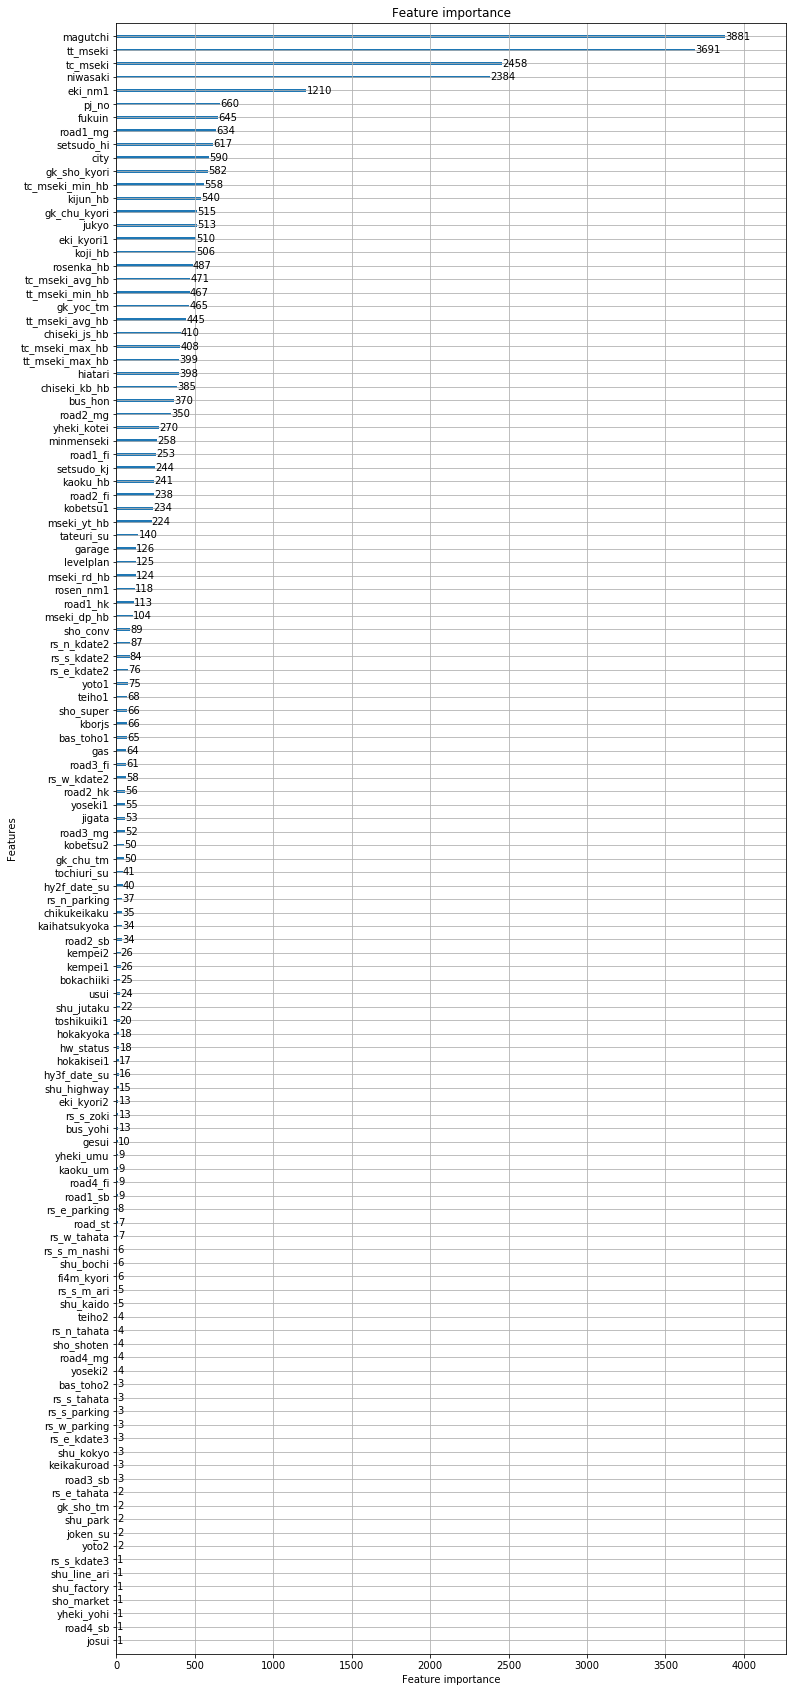

In [10]:
selected_X_train = pd.DataFrame()
selected_X_test = pd.DataFrame()
selected_X_eval   = pd.DataFrame()
for importance, col in zip(model.feature_importance(), X_train.columns):
    if importance > 0:
        selected_X_train[col] = X_train[col]
        selected_X_test[col] = test_X[col]
        selected_X_eval[col] = X_eval[col]

lgb_train_selected = lgb.Dataset(selected_X_train, y_train)
lgb_eval_selected = lgb.Dataset(selected_X_eval, y_eval, reference=lgb_train_selected)
model_selected = lgb.train(lgbm_params, lgb_train_selected, valid_sets=lgb_eval_selected, num_boost_round=10000, verbose_eval=500, early_stopping_rounds=1000)

lgb.plot_importance(model_selected, figsize=(12, 30))
plt.show()


### パラメータチューニング

In [11]:
import optuna


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def opt(trial):
    '''
    drop_rate = trial.suggest_uniform('drop_rate', 0, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0, 1.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.8, 1.0)
    num_leaves = trial.suggest_int('num_leaves', 5, 1000)
    verbosity = trial.suggest_int('verbosity', -1, 1)

    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 100000)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 500)
    min_child_weight = trial.suggest_int('min_child_weight', 5, 500)
 
    # http://kamonohashiperry.com/archives/209
    params = {
              　'objective': 'regression',
              　'metric': 'mape',
              　"boosting_type": "gbdt",
                "learning_rate": 0.1,
                "max_depth": trial.suggest_int('min_data_in_leaf', 3, 10),
                "min_child_weight": trial.suggest_int('min_child_weight', 0, 15),
              
            　　"num_leaves": num_leaves,
             　 "max_bin": 256,
              　"feature_fraction": feature_fraction,
              　"verbosity": verbosity,
              　"drop_rate": drop_rate,
              　"is_unbalance": False,
              　"max_drop": 50,
              　"min_child_samples": min_child_samples,
              　"min_split_gain": 0,
              　"min_data_in_leaf": min_data_in_leaf,
              　"subsample": subsample
              }
    '''
    params = {
            'objective': 'regression',
            'metric': 'mape',
            "boosting_type": "gbdt",    
            "learning_rate": 0.1,
            # L2 正則化
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e3),
            # L1 正則化
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e3),
            # 弱学習木ごとに使う特徴量の割合
            # 0.5 だと全体のうち半分の特徴量を最初に選んで, その範囲内で木を成長させる
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, .1),
            # 学習データ全体のうち使用する割合
            # colsample とは反対に row 方向にサンプルする
            'subsample': trial.suggest_discrete_uniform('subsample', .5, 0.9, .1),
            # 木の最大の深さ
            # たとえば 5 の時各弱学習木の各データに対するルールは、最大でも5に制限される.
            'max_depth': trial.suggest_categorical('max_depth', [3, 5, 6, 7, 8]),
            # 末端ノードに含まれる最小のサンプル数
            # これを下回るような分割は作れなくなるため, 大きく設定するとより全体の傾向でしか分割ができなくなる
            # [NOTE]: 数であるのでデータセットの大きさ依存であることに注意
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 20)
    }

    
    
    # train
    model = lgb.train(params, lgb_train_selected, valid_sets=lgb_eval_selected, num_boost_round=10000, verbose_eval=2000, early_stopping_rounds=1000)
    y_pred = model.predict(selected_X_eval, num_iteration=model.best_iteration)

    
    return mean_absolute_percentage_error(y_eval, y_pred)

optuna.logging.disable_default_handler()
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123))
study.optimize(opt, n_trials=10)

print('best_params')
print(study.best_params)
print('best_value')
print(study.best_value)

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[734]	valid_0's mape: 0.0738512
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[695]	valid_0's mape: 0.0743987
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.074949
Early stopping, best iteration is:
[2923]	valid_0's mape: 0.0747957
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[705]	valid_0's mape: 0.0734548
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[849]	valid_0's mape: 0.0733497
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0748523
Early stopping, best iteration is:
[2588]	valid_0's mape: 0.0746437
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[573]	valid_0's mape: 0.0741645
Training until v

In [13]:
params = {
        'objective': 'regression',
        'metric': 'mape',
        "boosting_type": "gbdt",    
        "learning_rate": 0.1,
}
params.update(study.best_params)
model = lgb.train(params, lgb_train_selected, valid_sets=lgb_eval_selected, num_boost_round=10000, verbose_eval=2000, early_stopping_rounds=1000)


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[499]	valid_0's mape: 0.0719403


In [14]:
model.predict(selected_X_eval, num_iteration=model.best_iteration)

array([30115755.86475669, 29476422.33605779, 26553376.17683483, ...,
       30014026.0780696 , 18389164.52814267, 25532135.10406557])

### 予測

In [17]:
ypred = model.predict(selected_X_test, num_iteration=model.best_iteration)
result = pd.DataFrame(columns=['id', 'pred'])
result['id'] = test_X['id']
result['pred'] = ypred
result.to_csv('result.tsv', index=False, header=False, sep='\t')